In [1]:
# This code works in Python 3.10.6
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import torch_geometric.transforms as T
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
import csv
import os
import os.path as osp

## Read PubMed dataset

In [3]:
df_nodes = pd.read_table(('node_pubmed.dat'),names=['node_id', 'node_name', 'node_type', 'node_attributes'],quoting=csv.QUOTE_NONE)

In [4]:
df_labels_train = pd.read_table(('label_pubmed.dat'),names=['node_id', 'node_name', 'node_type', 'node_label'])

In [5]:
df_labels_test = pd.read_table(('label_pubmed.dat.test'),names=['node_id', 'node_name', 'node_type', 'node_label'])

In [6]:
df_labels = pd.concat([df_labels_train, df_labels_test],ignore_index=True)

### Training data for GMM 

In [7]:
#Select the nodes of type 1 from original disease node featureswhich are labeled
df_disease=pd.merge(df_nodes, df_labels, on="node_id")[['node_id','node_attributes','node_label']]
df_disease = df_disease.reset_index()
df_disease.head()

,index,node_id,node_attributes,node_label
0,0,81,"0.293945,-1.118894,0.365789,0.826958,-1.024909...",2
1,1,382,"-0.076263,-0.1012,0.205599,-0.010939,0.011885,...",0
2,2,719,"-0.00509,-0.093002,0.155948,-1.041911,-0.11497...",1
3,3,1168,"-1.590567,-1.421712,1.546614,2.070439,-1.26965...",5
4,4,1183,"-0.047317,-0.141594,0.075213,-0.12674,-0.05318...",4


### Continuous features of 8 Disease node classes

In [8]:
def convert_string_to_float(df):
    return df['node_attributes'].apply(lambda x: np.fromstring(x, dtype=float, sep=',' ))

In [9]:
def preprecess_class(df_class):
    df_class = df_class.reset_index()
    df_class = convert_string_to_float(df_class)

    x = torch.tensor(df_class).float()
    disease_class = pd.DataFrame(x.numpy())
    return disease_class

In [10]:
class0 = df_disease[df_disease['node_label'] == 0].drop(['node_label','node_id'], axis = 1)
disease_class0 = preprecess_class(class0)
disease_class0.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.076263,-0.101200,0.205599,-0.010939,0.011885,-0.186806,0.017315,0.054221,-0.134682,0.029309,...,0.003725,-0.046961,0.022030,-0.059511,0.077090,0.027611,-0.119589,0.077600,-0.107299,0.150120
1,-0.105695,0.184201,-0.311365,-0.586918,0.041839,-0.375352,-0.209809,-0.275197,-0.187691,-0.010407,...,-0.295827,0.270551,0.139439,-0.118387,0.218033,0.240468,-0.405404,-0.024009,-0.038280,-0.079097
2,-0.027505,-0.145466,0.130640,-0.371549,0.082745,0.034039,-0.263921,0.326173,-0.230346,0.233040,...,-0.071879,-0.146309,0.144660,-0.052654,-0.092761,-0.082010,-0.002204,0.110625,-0.029077,-0.149880
3,-0.212835,0.020092,-0.067165,-0.360546,0.003719,-0.316084,-0.095670,-0.090671,-0.355869,0.123713,...,-0.042489,0.322580,0.213475,0.184327,0.126990,-0.174734,-0.356310,-0.022425,-0.208380,0.164806
4,0.176848,-0.177994,0.217688,-0.140722,-0.002420,-0.194984,-0.056105,0.126072,-0.111896,0.070906,...,-0.095619,-0.040588,0.164668,0.183074,-0.007102,-0.078018,-0.206885,-0.046569,-0.120863,0.097002


In [11]:
class1 = df_disease[df_disease['node_label'] == 1].drop(['node_label','node_id'], axis = 1)
disease_class1 = preprecess_class(class1)
disease_class1.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.005090,-0.093002,0.155948,-1.041911,-0.114979,-0.617497,0.166439,-0.113988,-0.443707,0.636185,...,-0.327394,0.439298,0.356134,0.690550,-0.308860,0.468901,0.244124,-0.058623,-0.368219,0.021397
1,0.678459,0.161107,-0.294408,-1.367651,2.103768,1.186129,1.882125,0.423219,-1.912892,1.194931,...,1.654857,1.608435,1.162236,-2.717319,-0.201214,1.197099,-1.264541,-2.922577,-1.188741,-1.307242
2,-1.681199,-0.703751,1.128087,-2.226594,-1.046119,0.636730,-0.500095,-0.239979,-0.998992,1.267447,...,2.065444,-1.046750,-2.627437,0.992201,0.717234,-2.367232,-2.050255,2.666933,-0.772199,0.401438
3,0.130749,-0.267213,1.721457,-0.982399,-0.044695,0.734526,-1.621730,0.373868,-0.232872,0.250372,...,-0.560398,0.781580,-0.162089,0.002168,0.013112,0.295674,-0.078259,0.097034,-0.650094,0.730890
4,0.465970,0.497691,-1.815122,-2.004339,-1.764053,-1.834500,0.539877,-1.023946,-1.697607,-0.490281,...,-0.737012,0.975823,-1.241157,0.261960,1.214548,-0.651538,-0.052915,-1.043717,-0.922041,1.584273


In [12]:
class2 = df_disease[df_disease['node_label'] == 2].drop(['node_label','node_id'], axis = 1)
disease_class2 = preprecess_class(class2)
disease_class2.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.293945,-1.118894,0.365789,0.826958,-1.024909,1.365870,-0.467886,0.515582,0.910748,1.669809,...,1.176890,-1.274171,-0.108948,-0.122850,0.121726,-0.147028,1.688417,-1.279368,-0.453393,-1.340375
1,-0.234695,-0.397418,-0.287049,-0.643192,-0.341378,-0.137831,0.152796,-0.083522,-0.232843,0.195185,...,0.211748,0.152090,0.104088,-0.103871,0.049093,0.222295,-0.139634,-0.290401,-0.421514,-0.226837
2,0.695679,-0.269031,-0.039114,-0.220264,0.207794,-0.019134,-0.248732,-0.059364,-0.408351,0.298378,...,0.260148,0.496637,-0.177052,-0.503436,0.183291,-0.307593,0.698607,0.043632,0.076104,0.478376
3,0.360314,-0.048848,0.084257,-0.308134,-0.118678,0.166424,-0.763351,0.002166,-0.790255,0.063675,...,-0.484946,0.004471,0.204809,-0.054277,0.325952,-0.179520,-0.097079,0.044739,-0.012146,-0.029781
4,-0.404648,-0.211988,0.180779,0.011021,0.246021,-0.108891,-0.292355,0.192935,-0.278896,0.114823,...,-0.048433,-0.053900,-0.057867,-0.046750,-0.020443,0.026236,-0.223835,-0.044477,-0.056810,-0.219431


In [13]:
class3 = df_disease[df_disease['node_label'] == 3].drop(['node_label','node_id'], axis = 1)
disease_class3 = preprecess_class(class3)
disease_class3.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.024643,0.083535,-0.118264,0.594446,-0.201284,-0.355791,-0.249425,0.963553,0.531981,0.146523,...,0.748214,0.242602,-0.510621,-1.191598,0.397599,-0.320266,0.024989,0.133490,1.125030,-0.851694
1,0.556467,-2.086023,1.777970,-0.953517,0.915395,1.392508,-1.678550,0.540311,1.287577,0.618743,...,-0.411275,0.044154,0.361089,-1.754970,0.017345,0.280704,-0.718187,-0.045025,-0.258995,-0.425449
2,0.399095,-0.033018,-0.050412,-0.308753,-0.270034,0.745800,0.109193,0.020682,0.472592,0.340427,...,0.173446,0.161498,0.315679,0.281295,-0.044803,0.013173,-0.458676,-0.137317,0.170523,0.214067
3,-0.240225,-1.536221,1.694471,0.427379,-1.573127,-1.249170,0.884610,0.263238,0.510730,1.645338,...,0.614007,0.541815,-2.998076,-2.450051,1.247795,-0.588532,3.193011,0.717154,0.347180,-1.627718
4,0.362348,-1.096200,0.676793,-0.413567,-0.772641,0.890930,-0.149459,0.236680,0.380899,0.178184,...,0.455985,-0.515523,0.660446,0.193103,0.302213,-0.151369,0.092068,0.212235,0.546388,0.454193


In [14]:
class4 = df_disease[df_disease['node_label'] == 4].drop(['node_label','node_id'], axis = 1)
disease_class4 = preprecess_class(class4)
disease_class4.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.047317,-0.141594,0.075213,-0.126740,-0.053180,-0.218182,0.010254,0.047152,-0.041381,0.002139,...,-0.163869,0.026139,0.029002,0.043187,0.089586,0.033324,-0.114441,-0.060817,-0.010271,0.124895
1,0.562200,-0.225132,1.403848,-0.900295,0.262917,0.775106,-1.395564,0.311257,-0.724682,0.510858,...,0.411451,0.706201,0.340969,0.616213,-0.581052,-0.016106,-0.312787,-0.254518,0.271065,-0.790870
2,0.132653,0.074229,0.130764,0.033300,-0.102414,-0.218270,-0.071465,0.149520,-0.059220,0.017269,...,-0.111331,0.032618,-0.101999,0.099495,0.009021,0.139706,-0.035738,0.021552,0.008510,0.002877
3,-0.017639,-0.033512,0.000192,-0.109765,0.026992,-0.011844,-0.011614,-0.025284,0.024664,0.010700,...,0.005757,0.102228,0.023747,0.007250,0.059213,0.070808,-0.047414,-0.096692,-0.043873,-0.066162
4,-0.131220,-0.051643,-0.041383,-0.281236,-0.046421,-0.136331,-0.069264,0.033541,-0.169223,0.180200,...,0.037729,-0.067685,0.098400,0.071199,0.224848,0.105085,-0.249451,-0.156987,-0.106818,0.112558


In [15]:
class5 = df_disease[df_disease['node_label'] == 5].drop(['node_label','node_id'], axis = 1)
disease_class5 = preprecess_class(class5)
disease_class5.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-1.590567,-1.421712,1.546614,2.070439,-1.269654,-3.492672,-0.985981,0.546692,-0.475412,-1.536833,...,0.422038,0.007902,-1.390627,-1.551006,0.566039,-0.957820,1.291253,-0.831003,-0.518681,-2.290930
1,1.707825,-0.382173,-1.978946,-0.982130,-0.596798,-1.058455,-0.786816,1.240825,-0.129001,0.208566,...,0.172373,3.154299,-0.672227,1.427703,1.280134,0.568588,-0.842362,-2.181951,1.627768,-0.607146
2,0.220100,-0.417449,-0.685131,0.271951,0.078659,-0.432255,0.099468,0.972583,0.090751,-0.106717,...,-0.402620,2.183498,-0.601318,1.458961,1.056984,0.751510,-1.148700,-1.398744,0.755516,-0.002951
3,-1.740684,0.606801,-1.877703,1.046687,0.026526,-0.971972,-0.062663,0.606383,-0.530064,-0.484855,...,0.776250,-1.420441,-0.033495,-0.917212,-0.367292,1.660141,-0.226066,1.478080,-0.249655,-0.803304
4,-0.115116,0.002367,-0.479038,-0.177523,0.033764,-0.129842,0.056449,-0.296631,-0.288493,-0.015120,...,-0.138466,-0.019240,-0.189517,-0.354875,0.412785,-0.289701,0.006733,0.096080,-0.055206,-0.724863


In [16]:
class6 = df_disease[df_disease['node_label'] == 6].drop(['node_label','node_id'], axis = 1)
disease_class6 = preprecess_class(class6)
disease_class6.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.705640,0.985807,1.727781,-0.572725,-1.510551,0.642899,-0.624731,-1.256330,0.380489,0.023940,...,0.237006,-0.864796,0.610489,0.725486,-0.615443,1.057366,-1.303320,-0.523200,-0.703197,0.300165
1,0.011111,-0.122398,0.108061,-0.168659,0.130440,-0.140680,-0.039575,0.006266,-0.134101,0.157674,...,-0.144526,0.049754,0.064575,0.282247,0.194395,0.082200,-0.225217,-0.088581,-0.127291,0.053279
2,1.179064,-0.248007,1.991181,0.059653,-1.148944,0.998520,-2.427823,0.023305,-1.135082,0.836730,...,0.554176,-0.339511,-0.320372,-0.973622,0.498973,0.603219,0.206073,-0.617010,0.398882,-0.659668
3,1.189486,-0.211165,1.973143,-0.170255,0.155388,0.033257,-1.330603,0.244563,-1.469571,0.941832,...,0.590651,-0.198665,0.922510,0.824605,-0.320789,-0.067372,-0.554014,-0.405515,-0.508741,-0.424119
4,0.355506,0.235083,0.229828,-0.683967,0.104608,-0.054153,-0.353290,-0.215031,-0.647038,0.664175,...,0.223206,-0.076717,0.368509,0.355019,-0.116577,0.160777,0.104109,-0.340245,-0.294386,0.067596


In [17]:
class7 = df_disease[df_disease['node_label'] == 7].drop(['node_label','node_id'], axis = 1)
disease_class7 = preprecess_class(class7)
disease_class7.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.008934,-0.107426,-0.025639,-0.182206,-0.061130,-0.204593,0.052291,0.000600,-0.019277,-0.035205,...,-0.004144,-0.114080,-0.111657,-0.027183,0.011316,0.052875,-0.172027,0.045929,-0.126126,0.006938
1,0.137979,-0.170588,0.379676,-0.133586,0.079844,-0.251604,-0.024294,-0.344566,0.012777,-0.011450,...,-0.218091,-0.112789,0.223476,0.009716,0.009727,-0.239896,-0.423860,0.127019,-0.208154,0.340889
2,-0.103373,-0.060679,0.032110,-0.060401,-0.028959,-0.040241,0.008029,0.002173,0.159710,0.096757,...,-0.051615,0.114342,-0.094867,0.182887,0.080529,0.035603,-0.051109,-0.036864,0.006196,-0.052524
3,-0.599056,-1.798572,0.036479,0.219410,-0.855767,-0.576619,1.906403,-1.219357,2.067185,-0.082776,...,0.970780,1.856780,-0.228110,0.857764,0.265307,0.256848,-0.150381,-0.285863,-1.042520,0.592658
4,1.363495,-0.065928,1.405803,-0.537324,-0.262326,-1.180556,0.268985,-0.565657,-0.405827,-1.344875,...,-0.853315,-0.385528,1.336321,0.695131,-0.434372,1.154994,0.586074,0.639965,-1.056659,-0.311664


### Fit Gaussian Mixture Models to 8 Disease node classes

In [18]:
new_features_dict = {}

In [19]:
def sample_nodes(model,node_type, n_samples):

    smpls = model.sample(n_samples)
    print("no of class {} node samples - {}".format(node_type, n_samples))
    return smpls[0]

In [20]:
def fit_sample_gm(df_class, node_type, n_samples):
    #fit
    model = GaussianMixture(n_components=1, covariance_type='full', random_state = 0)
    model.fit(df_class)
    #print("Mean for nodetype", node_type,model.means_)
    #sample
    smpls = sample_nodes(model, node_type, n_samples)
    new_features_dict[node_type] = smpls

In [21]:
fit_sample_gm(disease_class0, 'disease0', disease_class0.shape[0])
fit_sample_gm(disease_class1, 'disease1', disease_class1.shape[0])
fit_sample_gm(disease_class2, 'disease2', disease_class2.shape[0])
fit_sample_gm(disease_class3, 'disease3', disease_class3.shape[0])
fit_sample_gm(disease_class4, 'disease4', disease_class4.shape[0])
fit_sample_gm(disease_class5, 'disease5', disease_class5.shape[0])
fit_sample_gm(disease_class6, 'disease6', disease_class6.shape[0])
fit_sample_gm(disease_class7, 'disease7', disease_class7.shape[0])

no of class disease0 node samples - 69
no of class disease1 node samples - 52
no of class disease2 node samples - 48
no of class disease3 node samples - 39
no of class disease4 node samples - 98
no of class disease5 node samples - 64
no of class disease6 node samples - 42
no of class disease7 node samples - 42


### Continuous features sampled using Gaussian Mixure Models

In [22]:
disease0_sampled = pd.DataFrame(new_features_dict['disease0'])
disease0_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.086271,-0.593199,0.481723,-2.175027,-0.636149,-0.123930,-0.752506,0.216741,-0.033694,0.951046,...,1.262650,0.119189,-0.081354,-0.209360,0.079879,-1.007121,0.885314,-0.678727,-1.000276,0.764016
1,0.707258,0.139616,0.280470,-0.674589,-0.721606,-0.435582,-0.468024,0.035690,0.422899,0.464536,...,0.171383,-0.607000,-0.304012,0.673294,0.564850,-0.048241,0.507070,-0.226987,-0.332799,0.018928
2,-0.024572,-0.151074,-1.184926,-0.125710,-0.130525,-0.097576,-0.022600,-0.232580,0.047208,-0.363184,...,0.235765,-0.066631,0.970886,0.052890,-0.102155,0.997865,-0.513591,0.235357,-0.130651,0.814321
3,0.452711,0.217029,-0.014056,-0.158538,-0.165163,-0.301771,-0.434128,0.169635,-1.075119,0.341331,...,-0.842766,-0.521041,0.610894,0.320181,-0.059529,-0.904683,-0.712859,0.265404,0.281861,-0.397691
4,-0.334170,-0.429154,-0.140474,-1.528456,-0.450239,0.588510,0.319103,-0.161390,-0.360079,0.476956,...,0.792575,1.398145,0.061239,0.083345,0.241276,-0.723120,-0.631397,-0.451506,-0.829008,-0.068311


In [23]:
disease1_sampled = pd.DataFrame(new_features_dict['disease1'])
disease1_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.953068,-0.317761,-0.938789,1.030778,0.776145,-0.467975,0.860806,-0.336004,-0.228794,-0.251586,...,-0.076562,0.892206,0.740772,0.295915,-0.251871,0.194404,0.717489,1.277768,-0.972248,-0.215281
1,-0.970291,-0.506591,-0.639380,-1.170508,-0.486792,0.202388,0.154344,-0.400898,-1.002403,0.597118,...,1.138918,0.316891,-1.146671,0.065114,-0.454479,0.371013,1.006847,0.662326,-1.051807,-1.175435
2,-0.741746,-0.360580,0.024959,-1.408568,-0.180249,-0.001674,-0.320973,0.099513,-0.439897,1.389567,...,0.754809,-0.714588,-0.645971,-0.390024,0.205044,-0.888250,-0.239585,1.603387,0.061901,0.190665
3,-0.511079,0.143386,-0.968900,-0.817937,-0.788550,-0.312473,1.117115,-0.193306,-0.663928,0.479100,...,0.335955,0.684958,-0.191152,-0.309769,0.197239,0.534921,-0.525800,-1.627684,-0.592226,-0.978897
4,1.420019,-0.766439,0.167429,0.616098,-0.941761,-0.381966,-0.640576,0.391847,-0.475675,0.425944,...,-0.363698,0.029156,0.939605,0.518014,-0.401376,-0.519459,0.529754,0.175067,-0.134304,-0.317172


In [24]:
disease2_sampled = pd.DataFrame(new_features_dict['disease2'])
disease2_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.076780,0.482129,0.150471,0.463981,0.908665,0.844266,0.843275,0.867469,-0.805299,0.040516,...,0.169525,-0.687562,0.828563,-0.618116,0.048609,-1.638473,0.136673,-0.179945,0.865905,-1.304871
1,-0.636638,-0.392288,-0.537292,-0.376032,1.072720,0.504903,-0.214352,0.148207,-0.481301,0.085211,...,-0.216092,-0.585209,-0.339396,0.061867,0.403522,-0.356331,-0.513974,0.902819,-0.102804,0.293486
2,0.988131,-0.712993,-0.119075,-0.105674,-0.098366,0.404293,0.252372,-0.049856,-0.101753,-0.321955,...,0.756807,-0.129129,-1.026651,0.058443,-0.209613,0.596626,0.785235,0.099832,-0.635143,0.608835
3,-0.084290,-0.996643,0.226096,-1.472929,0.262656,0.133095,-1.482414,0.190244,-1.013713,1.024835,...,-0.157334,-0.323012,-0.253795,1.253292,-0.152061,0.546136,0.074147,1.232030,-0.113288,0.060688
4,-0.176168,0.267622,0.709486,0.274518,-0.309205,0.154483,-0.664411,0.019813,-0.174197,0.433595,...,-0.601620,-0.201438,1.153112,-0.568757,0.224357,-0.205451,-0.096505,-0.552148,0.073942,-1.753697


In [25]:
disease3_sampled = pd.DataFrame(new_features_dict['disease3'])
disease3_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.465295,-1.113954,0.607153,-0.071940,-0.443028,0.149584,1.836634,0.726774,0.958604,1.385416,...,-0.205466,1.871044,-0.000845,-0.007569,0.455864,-0.008278,0.276458,-0.374880,-0.090463,0.037343
1,-0.190117,0.183229,-0.511930,-0.056388,0.092749,-0.120519,0.314118,0.443842,0.479160,0.014331,...,-0.450995,0.435255,1.394021,0.300858,0.187560,0.333138,-0.980238,-0.401405,0.071669,0.170094
2,-0.278468,0.227799,-0.541420,-0.108239,-0.640097,0.045072,0.428929,1.028326,-0.194926,-0.085171,...,0.090630,0.120939,-0.009300,0.359026,-0.373459,0.599659,-0.326425,-1.426876,0.217517,-0.536191
3,-0.388874,0.597540,-0.927547,0.231687,-0.196595,-0.661869,-0.720716,-0.571608,-0.891718,0.090939,...,0.045074,-0.445960,0.713815,0.720173,0.471271,0.286800,-0.120330,-0.628559,-0.083914,-0.128819
4,-0.148532,-0.536704,0.750322,-0.441913,-0.300997,-0.495780,-0.416445,0.520974,0.537769,0.605064,...,-0.232943,0.211131,-1.043318,-1.064609,0.490629,0.283423,0.302553,-0.073425,-0.068832,-1.158108


In [26]:
disease4_sampled = pd.DataFrame(new_features_dict['disease4'])
disease4_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.328336,0.571573,0.339700,-0.138145,0.599385,-0.168309,-0.338664,-0.565946,0.670254,0.277382,...,0.324523,0.548883,-0.725617,-0.103921,0.415882,-0.764083,-0.318535,0.201562,0.215360,-0.590474
1,0.002314,0.063211,1.190526,-0.626002,0.504691,0.000266,-1.511606,0.350224,-1.233230,0.757909,...,-0.306738,0.147700,0.145820,0.523431,-0.437296,0.431412,-0.195005,0.489203,-0.137618,0.046071
2,0.422591,-0.171738,0.455956,-0.179492,0.401047,0.034519,-0.356890,0.162026,-0.691484,0.108571,...,0.108530,0.517026,1.020375,0.789719,0.146945,1.066979,-0.208682,-0.265883,-0.074539,1.042941
3,0.661798,-1.321565,1.525161,-0.668999,-0.650005,1.379783,-1.098058,0.582506,-0.676809,1.653240,...,-0.362437,-0.326193,0.402710,0.087193,-0.393332,-0.102459,-0.343902,-0.232801,0.012687,0.424479
4,0.240072,0.298705,0.179049,0.537036,-0.229319,-0.012102,0.241015,-0.008914,0.331796,-0.317034,...,-0.017418,-0.081728,-0.004392,-0.779241,0.392500,0.226791,0.054523,-0.434672,0.252423,-0.583004


In [27]:
disease5_sampled = pd.DataFrame(new_features_dict['disease5'])
disease5_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.124012,-0.261592,-1.684216,-1.482066,-0.220175,0.067500,-0.823963,1.510820,-0.554104,1.786381,...,-0.269146,1.711342,0.702961,1.495426,1.346523,1.312486,-0.675718,-2.502356,1.812869,-1.543187
1,-0.198234,0.383105,-1.278052,-0.401479,-0.120419,0.464618,-1.095460,0.404602,-0.508583,-0.272446,...,0.959471,0.969183,-0.419520,0.995240,-0.136150,0.637909,0.064587,-0.486304,1.370113,-0.761537
2,-0.228062,0.816475,0.632816,-0.175416,-0.157244,0.256821,0.317333,0.372174,-0.466553,-0.227121,...,-0.234031,0.066563,-0.595931,0.557179,-0.225509,1.264637,-0.014871,-0.795747,-1.202245,0.756873
3,-1.079104,0.268568,-0.700384,-1.113115,0.799727,0.561957,-0.886491,0.029855,-0.057872,0.312943,...,1.678177,-1.475863,-0.619250,-1.238466,-0.872271,-0.226516,0.771651,1.183093,-0.609371,-0.115133
4,0.951494,-0.470858,-0.160984,-0.781511,-0.286319,-1.417261,-0.354764,0.901473,-0.328499,0.663213,...,-0.386162,-0.026067,0.873503,0.801044,-0.090895,1.422796,-0.002889,-0.410235,1.179273,1.289823


In [28]:
disease6_sampled = pd.DataFrame(new_features_dict['disease6'])
disease6_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.038482,-0.244241,-0.234872,-0.061753,-0.010211,-0.837180,0.064015,1.070590,-1.183283,-0.273877,...,0.041310,-0.178283,-0.820806,0.443140,1.037399,-0.432421,0.474181,-0.204364,0.018725,0.046749
1,-0.322239,-0.460219,0.273935,-0.397933,0.490172,-0.252142,-0.719744,0.489734,-0.438464,0.038240,...,0.144742,-0.239011,-0.423841,0.399792,-0.059111,-0.014483,-0.130561,-0.524037,-0.421881,0.010508
2,-0.147585,-0.252827,0.449182,-0.273727,1.273570,0.391987,-0.171586,-0.235642,0.040051,0.218768,...,-0.386044,-0.137938,1.006234,0.604580,-1.460697,1.072691,-0.283689,0.626179,-0.816001,1.247875
3,0.882606,-0.131513,1.521988,-0.563608,0.517971,0.816429,-1.223582,0.097725,-1.120508,0.866976,...,0.275980,-0.094409,0.688486,0.690428,-0.753091,0.522223,-0.241039,-0.434303,-0.507444,-0.244816
4,0.350395,-0.268748,0.250320,0.260936,-0.451266,-0.204619,0.031911,0.077759,0.083742,0.090359,...,0.061803,0.103613,-0.118168,-0.064584,1.052293,-0.192097,-0.312311,0.186565,0.420811,-0.687346


In [29]:
disease7_sampled = pd.DataFrame(new_features_dict['disease7'])
disease7_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.233213,1.796088,-0.767680,0.084613,-1.569352,-0.769028,-1.023542,1.033228,-1.342659,-0.131290,...,-0.318637,-0.663840,-0.584767,0.447347,0.407087,-0.531600,0.612630,-0.749133,0.922963,-0.595892
1,0.514110,0.191800,0.215705,-0.428428,-0.838031,-1.032230,0.360125,-0.280157,-0.155574,-0.001794,...,0.361609,0.157894,-0.325989,0.560855,0.209375,-0.645518,0.957144,-0.880363,-0.966282,-0.364623
2,1.191982,-0.315649,0.897099,-0.492021,-0.450636,-0.892297,0.602574,-0.422500,-0.028908,0.339775,...,-0.047910,0.282988,0.523874,0.402132,-0.781567,0.298037,-0.184921,0.039325,-1.784981,0.538974
3,0.130430,-0.632924,1.595261,-0.477367,-0.612879,0.528540,0.873283,-1.568935,1.139012,0.655630,...,1.097606,1.840598,0.796597,0.018921,0.672772,0.727185,0.782245,0.443743,-1.894964,-0.467644
4,-0.005140,0.413161,-0.482928,-0.163475,0.152981,-0.427255,-0.102899,0.555644,-0.086842,-0.159581,...,-0.509889,-0.433858,-0.032691,0.331187,-0.159135,-0.379782,-0.879930,-0.029992,1.254936,0.700728


### Comparison of real and synthetic distributions for all features

In [30]:
def plot_all_feat(all_feat):
    sns.distplot(all_feat,hist= False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density',fontsize=15)

    plt.show() 

In [31]:
def plot_imp_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density',fontsize=15)

    plt.show() 

In [32]:
 def compare_plot(real,syn):    

    fig, ax = plt.subplots(figsize=(7.8,5))
    
    sns.distplot(real, label='real', ax=ax , hist= False)
    sns.distplot(syn, label='synthetic', ax=ax , hist= False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density',fontsize=15)
    ax.legend(fontsize=15, loc ="upper right")
    plt.show()

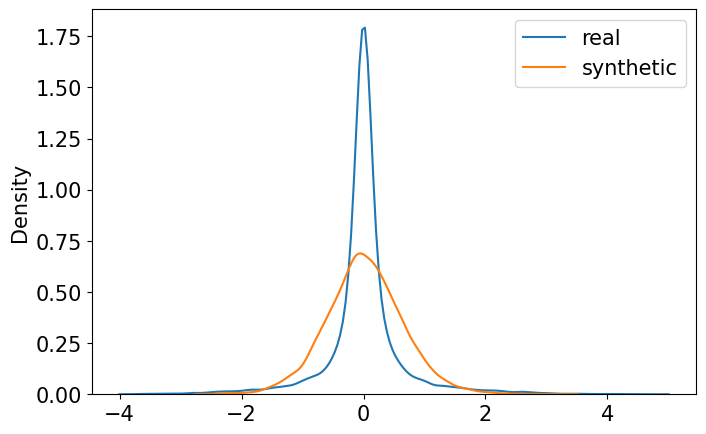

In [76]:
compare_plot(disease_class0, disease0_sampled)

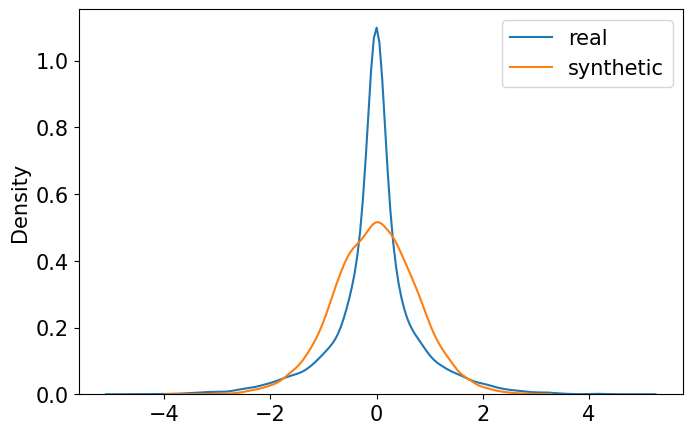

In [77]:
compare_plot(disease_class1, disease1_sampled)

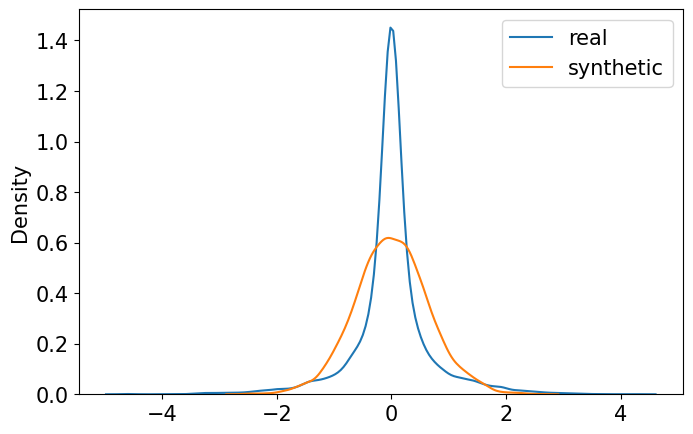

In [78]:
compare_plot(disease_class2, disease2_sampled)

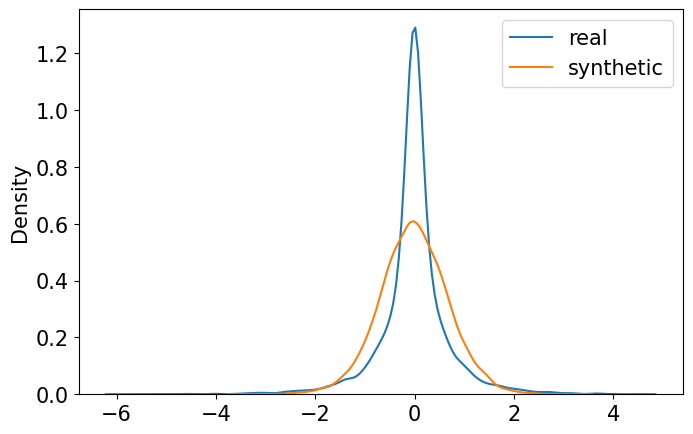

In [79]:
compare_plot(disease_class3, disease3_sampled)

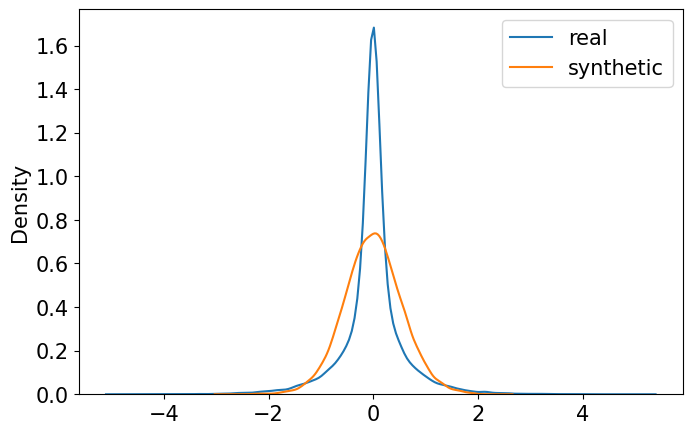

In [80]:
compare_plot(disease_class4, disease4_sampled)

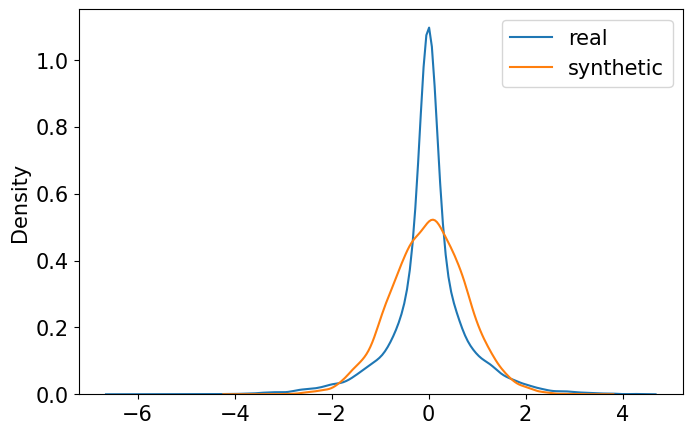

In [81]:
compare_plot(disease_class5, disease5_sampled)

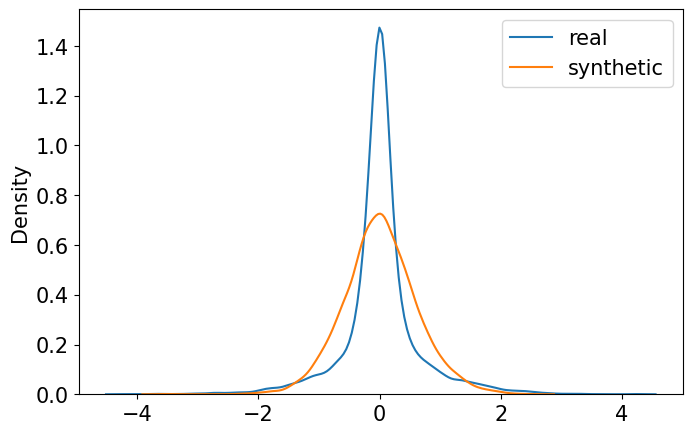

In [82]:
compare_plot(disease_class6, disease6_sampled)

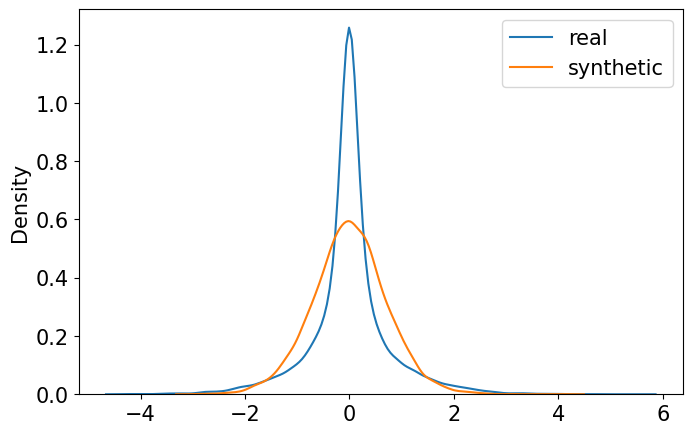

In [83]:
compare_plot(disease_class7, disease7_sampled)

### Comparison of real and synthetic distributions for the most important feature

In [41]:
corr = disease_class0.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.45).any()
real0 = corr.loc[m]
real0.index

Int64Index([193], dtype='int64')

In [42]:
corr = disease0_sampled.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.51).any()
syn0 = corr.loc[m]
syn0.index

Int64Index([151], dtype='int64')

In [43]:
real_imp_feat0 = disease_class0[[real0.index[0]]]
syn_imp_feat0 = disease0_sampled[[syn0.index[0]]]

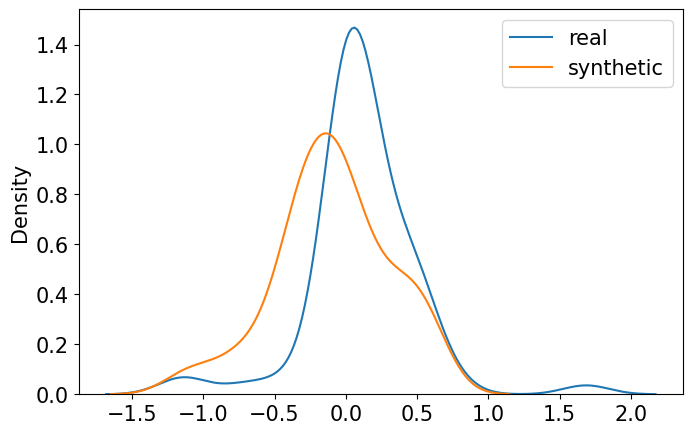

In [44]:
compare_plot(real_imp_feat0, syn_imp_feat0)

In [45]:
corr = disease_class1.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.45).any()
real1 = corr.loc[m]
real1.index

Int64Index([6], dtype='int64')

In [46]:
corr = disease1_sampled.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.49).any()
syn1 = corr.loc[m]
syn1.index

Int64Index([74], dtype='int64')

In [47]:
real_imp_feat1 = disease_class1[[real1.index[0]]]
syn_imp_feat1 = disease1_sampled[[syn1.index[0]]]

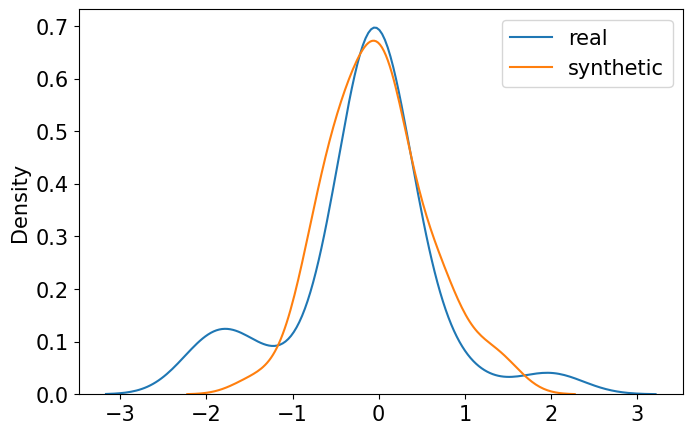

In [48]:
compare_plot(real_imp_feat1, syn_imp_feat1)

In [49]:
corr = disease_class2.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.45).any()
real2 = corr.loc[m]
real2.index

Int64Index([17], dtype='int64')

In [50]:
corr = disease2_sampled.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.53).any()
syn2 = corr.loc[m]
syn2.index

Int64Index([17], dtype='int64')

In [51]:
real_imp_feat2 = disease_class2[[real2.index[0]]]
syn_imp_feat2 = disease2_sampled[[syn2.index[0]]]

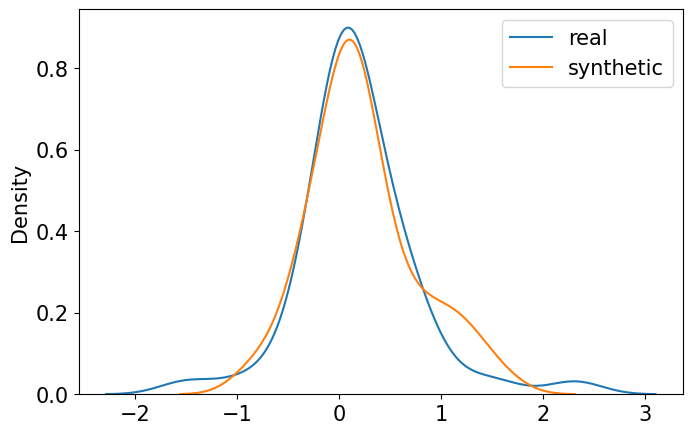

In [52]:
compare_plot(real_imp_feat2, syn_imp_feat2)

In [53]:
corr = disease_class3.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.54).any()
real3 = corr.loc[m]
real3.index

Int64Index([149], dtype='int64')

In [54]:
corr = disease3_sampled.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.53).any()
syn3 = corr.loc[m]
syn3.index

Int64Index([55], dtype='int64')

In [55]:
real_imp_feat3 = disease_class3[[real3.index[0]]]
syn_imp_feat3 = disease3_sampled[[syn3.index[0]]]

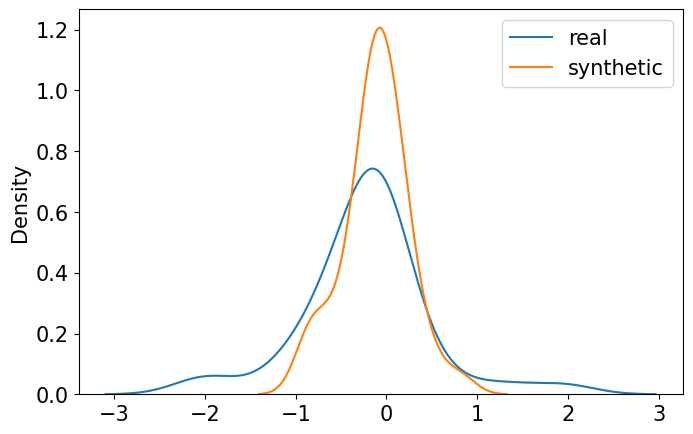

In [56]:
compare_plot(real_imp_feat3, syn_imp_feat3)

In [57]:
corr = disease_class4.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.45).any()
real4 = corr.loc[m]
real4.index

Int64Index([73], dtype='int64')

In [58]:
corr = disease4_sampled.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.45).any()
syn4 = corr.loc[m]
syn4.index

Int64Index([156], dtype='int64')

In [59]:
real_imp_feat4 = disease_class4[[real4.index[0]]]
syn_imp_feat4 = disease4_sampled[[syn4.index[0]]]

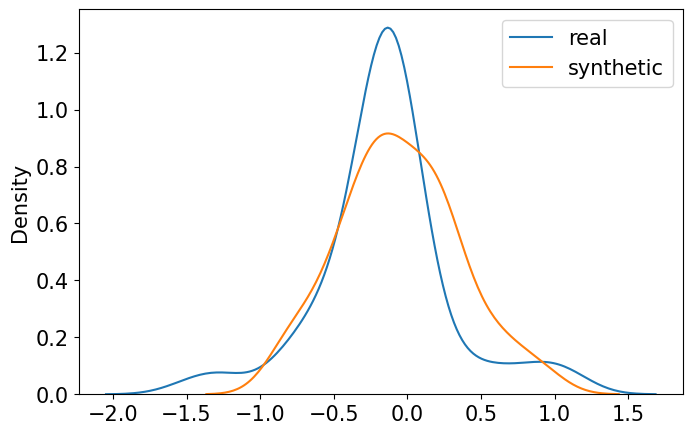

In [60]:
compare_plot(real_imp_feat4, syn_imp_feat4)

In [61]:
corr = disease_class5.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.407).any()
real5 = corr.loc[m]
real5.index

Int64Index([159], dtype='int64')

In [62]:
corr = disease5_sampled.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.474).any()
syn5 = corr.loc[m]
syn5.index

Int64Index([73], dtype='int64')

In [63]:
real_imp_feat5 = disease_class5[[real5.index[0]]]
syn_imp_feat5 = disease5_sampled[[syn5.index[0]]]

In [64]:

syn_imp_feat5.shape

(64, 1)

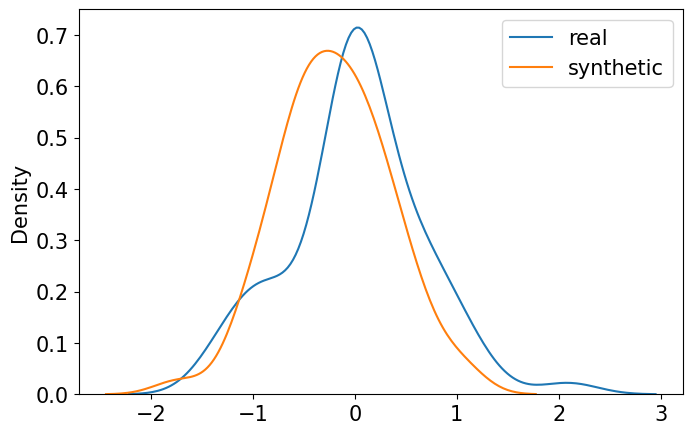

In [65]:
compare_plot(real_imp_feat5, syn_imp_feat5)

In [66]:
corr = disease_class6.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.5).any()
real6 = corr.loc[m]
real6.index

Int64Index([91], dtype='int64')

In [67]:
corr = disease6_sampled.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.5).any()
syn6 = corr.loc[m]
syn6.index

Int64Index([74], dtype='int64')

In [68]:
real_imp_feat6 = disease_class6[[real6.index[0]]]
syn_imp_feat6 = disease6_sampled[[syn6.index[0]]]

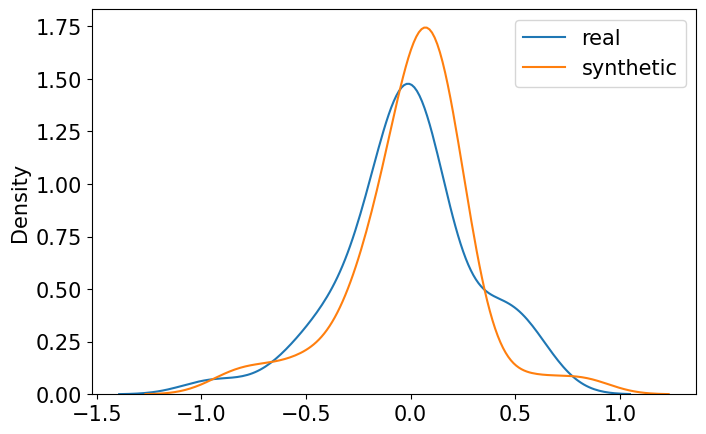

In [69]:
compare_plot(real_imp_feat6, syn_imp_feat6)

In [70]:
corr = disease_class7.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.54).any()
real7 = corr.loc[m]
real7.index

Int64Index([46], dtype='int64')

In [71]:
corr = disease7_sampled.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.58).any()
syn7 = corr.loc[m]
syn7.index

Int64Index([87], dtype='int64')

In [72]:
real_imp_feat7 = disease_class7[[real7.index[0]]]
syn_imp_feat7 = disease7_sampled[[syn7.index[0]]]

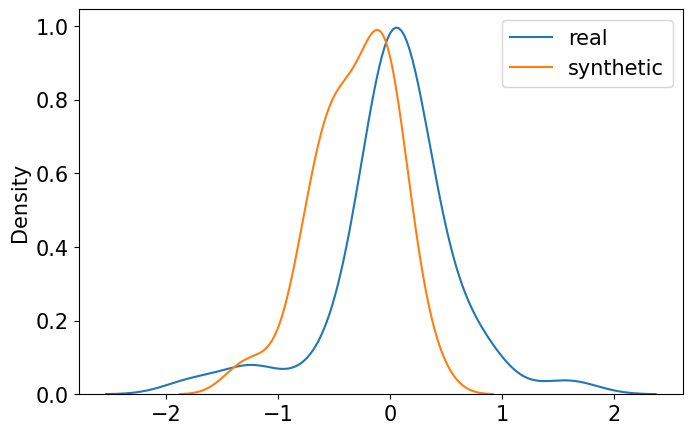

In [73]:
compare_plot(real_imp_feat7, syn_imp_feat7)

### Pairwise cosine similarity of all features for real and synthetic distributions

In [74]:
def cosine_sim(original,sampled):
    return cosine_similarity(np.array(original), np.array(sampled))

<Axes: >

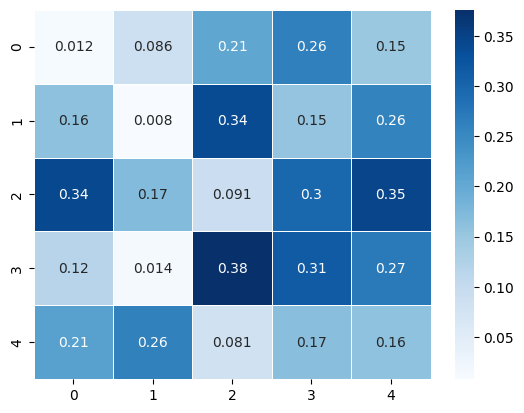

In [75]:
sns.heatmap(cosine_sim(disease_class0.iloc[:5],disease0_sampled.iloc[:5]), 
            xticklabels = 1, annot=True, yticklabels = 1,fmt=".2g", cmap='Blues', linewidth=.5)

<Axes: >

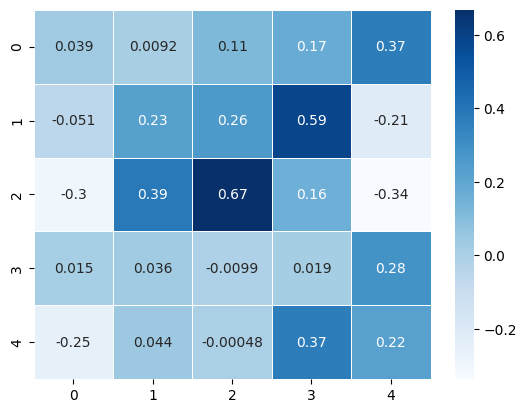

In [84]:
sns.heatmap(cosine_sim(disease_class1.iloc[:5],disease1_sampled.iloc[:5]), 
            xticklabels = 1, annot=True, yticklabels = 1,fmt=".2g", cmap='Blues', linewidth=.5)

<Axes: >

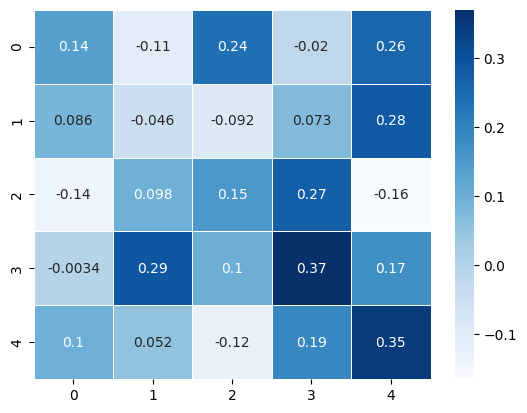

In [85]:
sns.heatmap(cosine_sim(disease_class2.iloc[:5],disease2_sampled.iloc[:5]), 
            xticklabels = 1, annot=True, yticklabels = 1,fmt=".2g", cmap='Blues', linewidth=.5)

<Axes: >

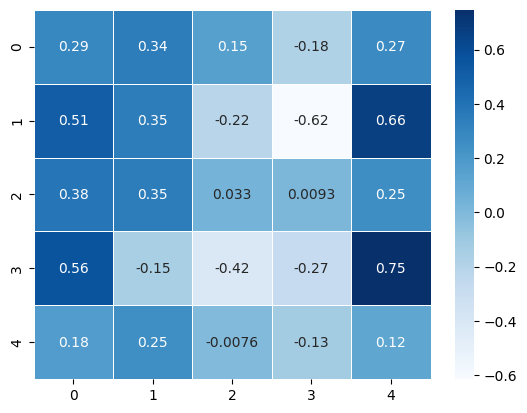

In [86]:
sns.heatmap(cosine_sim(disease_class3.iloc[:5],disease3_sampled.iloc[:5]), 
            xticklabels = 1, annot=True, yticklabels = 1,fmt=".2g", cmap='Blues', linewidth=.5)

<Axes: >

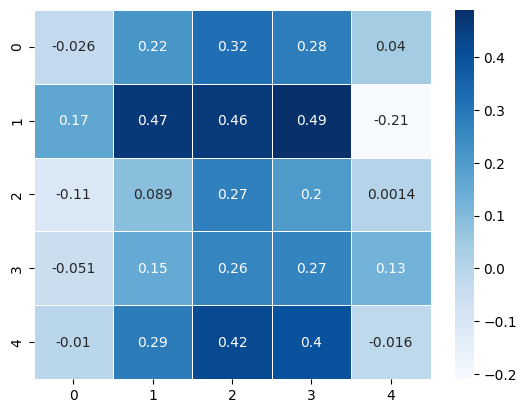

In [87]:
sns.heatmap(cosine_sim(disease_class4.iloc[:5],disease4_sampled.iloc[:5]), 
            xticklabels = 1, annot=True, yticklabels = 1,fmt=".2g", cmap='Blues', linewidth=.5)

<Axes: >

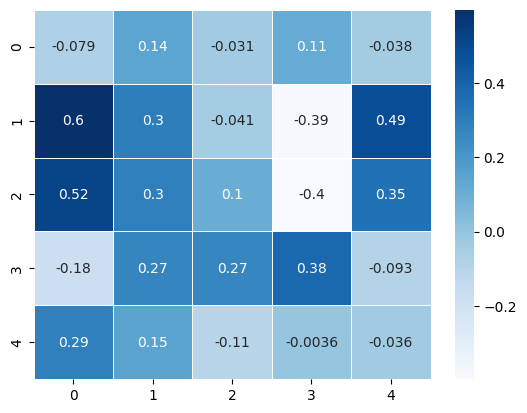

In [88]:
sns.heatmap(cosine_sim(disease_class5.iloc[:5],disease5_sampled.iloc[:5]), 
            xticklabels = 1, annot=True, yticklabels = 1,fmt=".2g", cmap='Blues', linewidth=.5)

<Axes: >

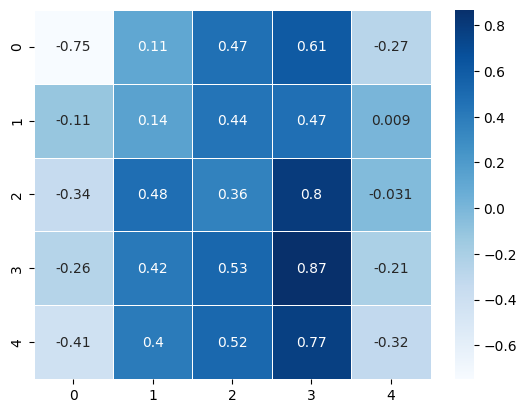

In [89]:
sns.heatmap(cosine_sim(disease_class6.iloc[:5],disease6_sampled.iloc[:5]), 
            xticklabels = 1, annot=True, yticklabels = 1,fmt=".2g", cmap='Blues', linewidth=.5)

<Axes: >

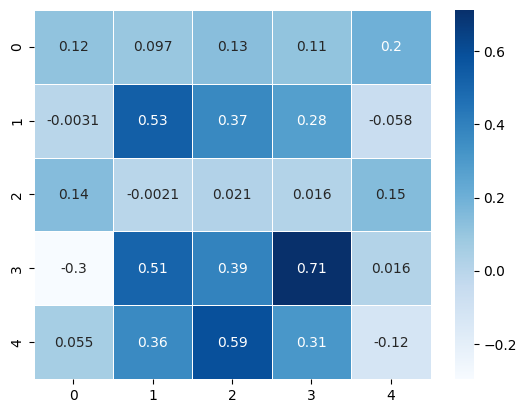

In [90]:
sns.heatmap(cosine_sim(disease_class7.iloc[:5],disease7_sampled.iloc[:5]), 
            xticklabels = 1, annot=True, yticklabels = 1,fmt=".2g", cmap='Blues', linewidth=.5)